# Advanced Lane Finding

### Through out this this notebook our goals will be to do the following tasks:
* Calibration of the forward facing camera found in the vehicle.
* Apply the correction to raw images found from the vehicle video stream.
* Apply color transforms, directional gradients, we will produce a much better lane detecting image.
* Apply a perspective transform the lane detected images to over head view images.
* We will generate a lane pixel detect and fit function.
* With the fits we can determine the curvature of the lane and vehicle position with respect to center.
* Finally we'll warp the detected lane boundaries back onto the original image for the video stream with annotated information.

[image3]: ./examples/binary_combo_example.jpg "Binary Example"
[image4]: ./examples/warped_straight_lines.jpg "Warp Example"
[image5]: ./examples/color_fit_lines.jpg "Fit Visual"
[image6]: ./examples/example_output.jpg "Output"
[video1]: ./project_video.mp4 "Video"

In [120]:
# import the required modules
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

### Camera Calibration

All cameras do not make perfect represetations of the real world.  There is always some soruce of noise when encoding the information about where objects are in the world into a 2-D image.  Some of the major sources of error come from effects of the lens and CCD detection plane orientation.  OpenCV provides a way to compute how a standard set of real world objects with known properties (in our case a chess board pattern) is transformed into an image a camera would generate by assuming the major factors are radial lens effects, and sheer effects from non-perpendicular CCD surface to the lens housing.  In order to attempt to correct these systematic error sources, we provide OpenCV with a series of calibration images taken with a single camera along with the 3D known location of several points in the images. When feed these images, and the real world location of points in the images, an inversion of the distortion effects can be approximated and applied to any image taken with the same camera to give a better representation of what an ideal camera would generate.  The steps to complete this calibration in OpenCV are done below.

In [7]:
# file paths to the calibration images
images_filepaths = glob.glob('camera_cal/calibration*.jpg')
print("there are {} calibration images".format(len(images_filepaths)))

there are 20 calibration images


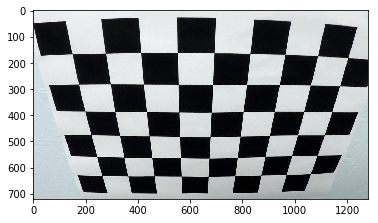

In [13]:
# lets take a look at one
img = cv2.imread(images_filepaths[5])
plt.imshow(img);

In [16]:
# so we've got a standard 9x6 chess board pattern
# we'll assume the object points are the intersection points
# of the chessboard pattern, as highlighted below
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# coords are in (y,x) format
corners_foundQ,corners_coords= cv2.findChessboardCorners(gray, (9,6),None)
corners_coords = corners_coords.reshape(-1,2)

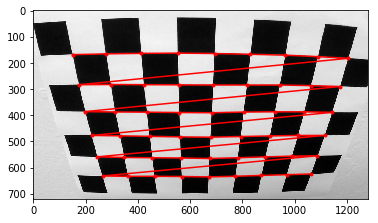

In [26]:
# lets draw the detected points
plt.imshow(gray,cmap='gray');
plt.plot(corners_coords.T[0],corners_coords.T[1],marker='.',c='r');

In [33]:
# now in order to map the detected corners to a real world object
# we need to know each corners location in a 3D space where the 
# origin is place at the upper left corner and we image the true
# pattern is placed at z=0

real_objpts = np.zeros((6*9,3), np.float32)
real_objpts[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

In [34]:
# some example points
real_objpts[:10]

array([[0., 0., 0.],
       [1., 0., 0.],
       [2., 0., 0.],
       [3., 0., 0.],
       [4., 0., 0.],
       [5., 0., 0.],
       [6., 0., 0.],
       [7., 0., 0.],
       [8., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [36]:
# for each image we need the real world coordinates,
# we'll store the real world coordinates in a list
imgs_real_objpts = [] # 3d points in real world space
imgs_img_points = [] # 2d points in image plane.

# for each chessboard image see if you can
# find al the corners, if so add it to the
# lists in order to invert later.
for image_file in images_filepaths:
    img = cv2.imread(image_file)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    corners_foundQ,corners_coords = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if corners_foundQ == True:
        imgs_real_objpts.append(real_objpts)
        imgs_img_points.append(corners_coords)

In [94]:
# Do camera calibration given object points and image points
img_shape = (gray.shape[1],gray.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(imgs_real_objpts, imgs_img_points, img_shape,None,None)

This calibration computes a series of transformation steps such that any real world object given by its coordinates in the base coordinate system $r_i = (X_i,Y_i,Z_i)$ are transformed to its pixel positions in the 2D image space given by $(u_i,v_i)$.  The transformation steps are an application of translation and rotation of real world points

$r'_i = R\cdot r_i + t$

where $R$ is a rotation matrix intrinsitic to the plane of the camera CCD and $t$ a translation vector intrinsitc to the placement of the CCD in the camera housing. After this is performed, the coordinates are scaled by the distance from the camera,

$r''_i = r'_i/z_i$

We then apply a transformation that undoes the effects of the distortion of the camera lens

$x'''_i = x''_i \frac{1+k_1 r^2 + k_2 r^4 +k_3 r^6}{1+k_4 r^2 + k_5 r^4 +k_6 r^6}+2 p_1 x''_i y''_i +p_2 (r^2+2 x'^2)$

$y'''_i = x''_i \frac{1+k_1 r^2 + k_2 r^4 +k_3 r^6}{1+k_4 r^2 + k_5 r^4 +k_6 r^6}+p_1 (r^2+2 (y''_i)^2) +2 p_2 x''_i y''_i$

where $r^2=(x''_i)^2+(y''_i)^2$ and the distortion coefficents are found in the variable dist.  Finally the image is focused onto the CCD via passage through the lens giving.

$u_i = f_x x'''_i + c_x$

$v_i = f_y y'''_i + c_y$

these lens parameters are collected in the "camera matrix" stored in the varaible mtx above.

In [86]:
# distortion coefficients
dist

array([[-0.24688775, -0.02373133, -0.00109842,  0.00035108, -0.00258571]])

In [87]:
# Camera Matrix
mtx

array([[1.15777930e+03, 0.00000000e+00, 6.67111054e+02],
       [0.00000000e+00, 1.15282291e+03, 3.86128937e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

We can invert the entire process for each image to produce images that would be generated from a nearly perfect camera.

In [95]:
img = cv2.imread(images_filepaths[5])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ideal_img = cv2.undistort(gray, mtx, dist, None, mtx)

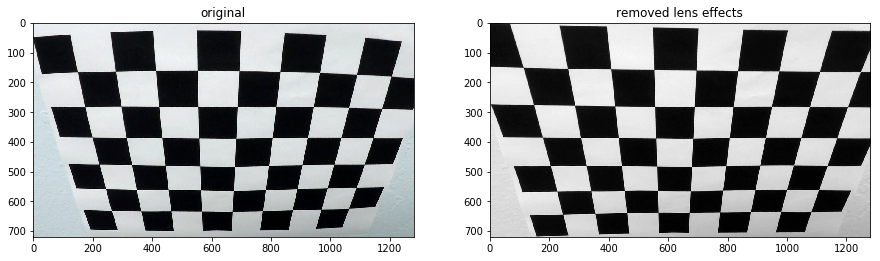

In [96]:
# take note of the rounded edges towards the outter edges of the images being corrected
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
ax1.imshow(img,cmap='gray')
ax1.set_title('original', fontsize=12)
ax2.imshow(ideal_img,cmap='gray')
ax2.set_title('removed lens effects', fontsize=12);

### Perspective transform

After the lens/CCD effects are removed we have a nearly ideal image, but unforuntely we can't make too many useful measurements on the image when we're not looking stright on to the standardized object.  In order to transform an image to a new perspective, we use OpenCV's tools to make a transformation of the image where refrence points on the image are mapped to the orientation you would like.  After the warping transformation is calculated, each pixel is mapped to the new oreintation.  When you spread some of the pixels during the warping process, there becomes partsof the image where there is no pixel information. To fill in those pixels an interpolation method is used to make a good guess of the pixel values in the new perspective. The application of this is done below.

In [107]:
# this is a special case function that works on chessboard patterns
# with auto detection of chessboard points
def normal_perspective_chessboard(raw_img, camera_mtx, distortion_coefs,nx=9,ny=6,recursion=0):
    if recursion == 10:
        print('Unable to find corners at all')
        warped = raw_img
        M = np.zeros(1)
        return warped,M
    
    undist = cv2.undistort(raw_img, camera_mtx, distortion_coefs, None, camera_mtx)
    gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)
    cornersFound, corner_coords = cv2.findChessboardCorners(gray, (nx,ny), None)
    
    if cornersFound == True:
        print('({},{}) corners found'.format(nx,ny))
        # putting the cords into rows of (y,x) pairs
        src = corner_coords.reshape(-1,nx,2)
        
        UL = src[0,0] #img upper left
        UR = src[0,-1]#img upper right
        LL = src[-1,0] #img lower left
        LR = src[-1,-1] #img lower right
        
        src = np.float32([UL,UR,LL,LR])
        
        ulx,uly = UL
        lrx,lry = LR   
        # destination cordinates is perfect rectangle
        dst = np.float32([[ulx,uly],[lrx,uly],[ulx,lry],[lrx,lry]])
        # get the linear warp matrix
        M = cv2.getPerspectiveTransform(src,dst)
        #apply warp matrix
        warped = cv2.warpPerspective(gray,M,gray.shape[::-1], flags=cv2.INTER_LINEAR)
    else:
        print('chessboard corners could not automatically be found reducing nx')
        warped,M=normal_perspective_chessboard(raw_img, camera_mtx, distortion_coefs,nx-1,ny,recursion+1)
    
    return warped, M

In [108]:
new_perspective,perspective_mtx = normal_perspective_chessboard(img,mtx,dist)

chessboard corners could not automatically be found reducing nx
(8,6) corners found


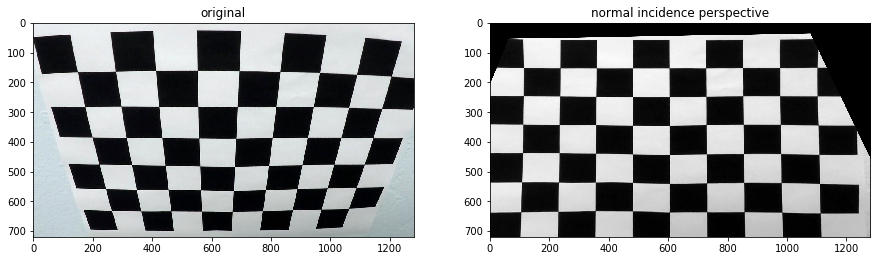

In [112]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
ax1.imshow(img,cmap='gray')
ax1.set_title('original', fontsize=12)
ax2.imshow(new_perspective,cmap='gray')
ax2.set_title('normal incidence perspective', fontsize=12);

#### Applying to Road Images

Here we're going use the calibration transform to correct images captured by our car mounted camera. After we correct for lens and CCD effects we're going to look at how we can apply some color space transformations and use some directional gradients on the images to see if we can do better than Canny edge detection as was done before. First lets correct an image.

In [113]:
# file paths to the road images
road_image_paths = glob.glob('test_images/*.jpg')
print("there are {} test road images".format(len(road_image_paths)))

there are 8 test road images


In [117]:
img = cv2.imread(road_image_paths[0])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ideal_img = cv2.undistort(gray, mtx, dist, None, mtx)

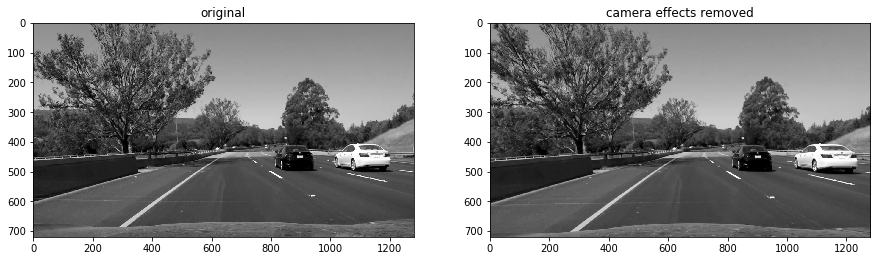

In [118]:
# notice how the size of the rear bumper of the white car is much larger 
# than in the raw image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
ax1.imshow(gray,cmap='gray')
ax1.set_title('original', fontsize=12)
ax2.imshow(ideal_img,cmap='gray')
ax2.set_title('camera effects removed', fontsize=12);

### Color transforms and directional gradients for better lane detection.

Ultimately our goal is to be able to track the lane lines much better than our previous attempt. In order to do that we'll want to apply our camera effect correction but before that we need to transform the color information into something binary/grayscale that will be very useful for our search for the lane lines.  

One of the major challenges of being able to detect lane lines from camera data is that the lighting conditions can vary wildly as you travel down the road.  Furthermore the road lane markers are not some standard color on all roads, as over time the lane markers can fade or become discolored.  What does remain in these different conditions is a concept called Hue.  All images can be decomposed into RGB channels but this is not the only color space basis.  We can use HSV or HSL color spaces to represent the image as well.  The major advantage of these alternative color spaces is brightness and base colors (like dark red or light red have a common base color of red) are the channels rather than just RGB colors.  Lets take a look at the road way images in these other color spaces to see some valueable information come to light. 

In [603]:
img = mpimg.imread(road_image_paths[0])
# transforming to the HLS color space
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

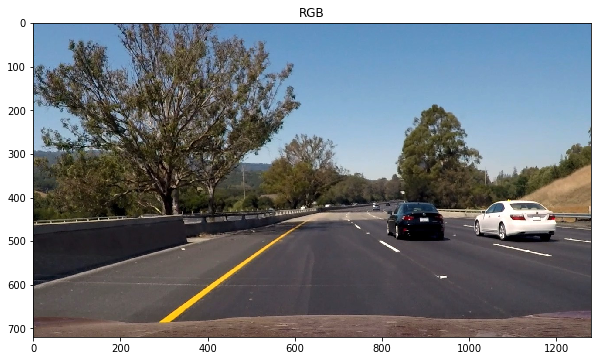

In [135]:
# Plot the colorspaces
plt.figure(figsize=(10, 9))
plt.title('RGB', fontsize=12)
plt.imshow(img);

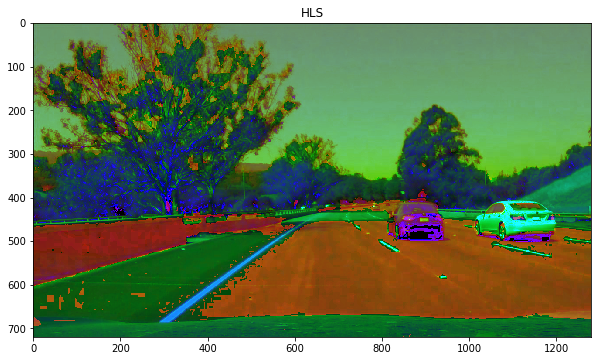

In [136]:
# Plot the result
plt.figure(figsize=(10, 9))
plt.title('HLS', fontsize=12)
plt.imshow(hls);

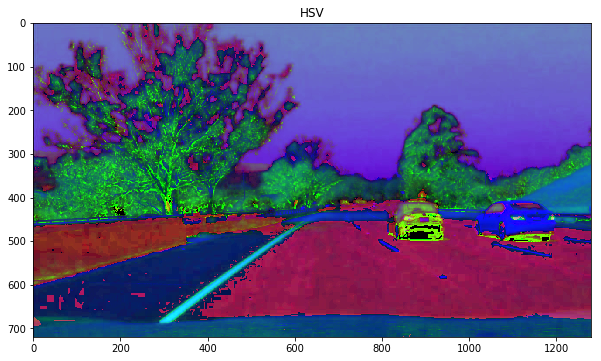

In [137]:
# Plot the result
plt.figure(figsize=(10, 9))
plt.title('HSV', fontsize=12)
plt.imshow(hsv);

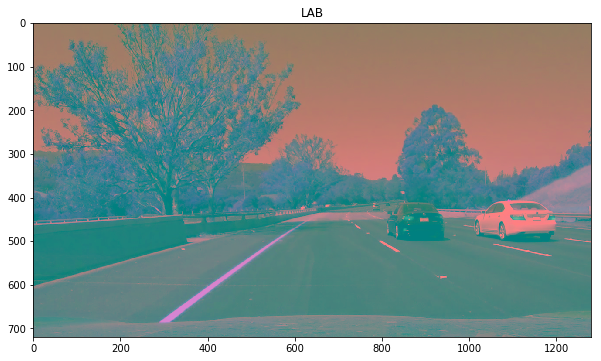

In [604]:
# Plot the result
plt.figure(figsize=(10, 9))
plt.title('LAB', fontsize=12)
plt.imshow(lab);

Looks like in the HSL color space that the lane markings are clearly highlighted even in the shadows! We can threshold this color spaces to extract very particular and useful pixels from the image.

In [191]:
def color_space_thresh(img, thresh=(0, 255)):
    tmp = np.copy(img)
    # 3 channel images
    if len(img.shape) == 3:
        for ch in range():
            tmp[~((img[:,:,ch]>thresh[0]) & (img[:,:,ch]<=thresh[1]))] = 0
    else:
        # binary images
        tmp[~((img>thresh[0]) & (img<=thresh[1]))] = 0
        
    return tmp

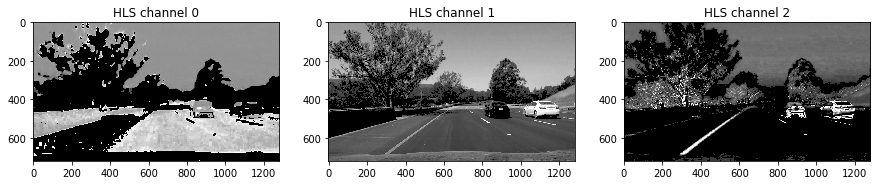

In [321]:
# applying thresholds on the color channels for HLS space
threshelds = [color_space_thresh(hls[:,:,ch],(50,255)) for ch in range(3)]

f, axs = plt.subplots(1, 3, figsize=(15,7))
for idx in range(len(axs)):
    axs[idx].imshow(threshelds[idx],cmap='gray')
    axs[idx].set_title('HLS channel '+str(idx), fontsize=12);

Looks like the S-channel with an image mask would be a very good way of detecting lane lines reguardless of shadows or direct lighting. Lets see if the other color spaces provide any useful features while we're here.

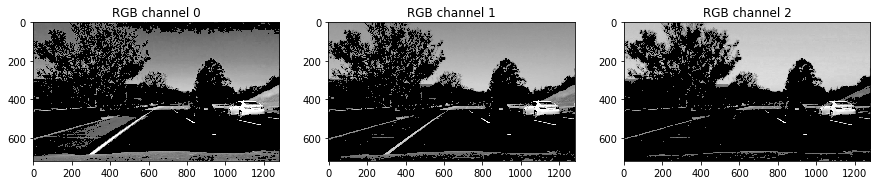

In [214]:
# applying thresholds on the color channels for RGB space
threshelds = [color_space_thresh(img[:,:,ch],(100,255)) for ch in range(3)]

f, axs = plt.subplots(1, 3, figsize=(15,7))
for idx in range(len(axs)):
    axs[idx].imshow(threshelds[idx],cmap='gray')
    axs[idx].set_title('RGB channel '+str(idx), fontsize=12);

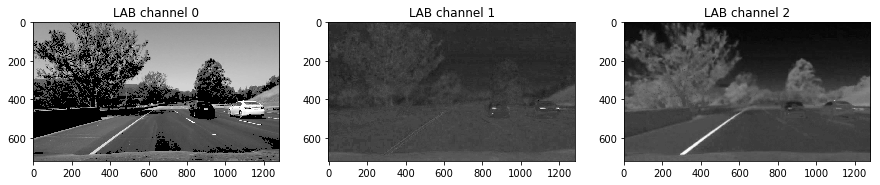

In [613]:
# applying thresholds on the color channels for HLS space
threshelds = [color_space_thresh(lab[:,:,ch],(70,255)) for ch in range(3)]

f, axs = plt.subplots(1, 3, figsize=(15,7))
for idx in range(len(axs)):
    axs[idx].imshow(threshelds[idx],cmap='gray')
    axs[idx].set_title('LAB channel '+str(idx), fontsize=12);

hmm some combination of the red and green channel might be useful to detect shades of yellow. But perhaps it would be easier to select a particular hue range, lets explore that.

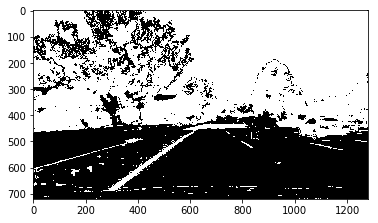

In [314]:
# applying thresholds and applify the results on the color channels for HLS space

# selecting oranges through yellows
hue_selection = color_space_thresh(hls[:,:,0],(15,70))
hue_selection[hue_selection.nonzero()] = 1

# selecting things near white
bright_selection = color_space_thresh(hls[:,:,1],(130,255))
bright_selection[bright_selection.nonzero()] = 1

binary_img = np.zeros_like(hue_selection)
# yellows or whites
binary_img[(bright_selection == 1) | (hue_selection == 1)] = 1

plt.imshow(binary_img,cmap='gray');

Hmmm not very clean...We could experiment with adapative contrasting in OpenCV as createCLAHE but in some of my experiements, I did not find any extreme gain in feature extraction. Lets continue with the L and S channels and see if applying directional gradients can be helpful to our lane detection before image correction.

In [842]:
# function applys a directional gradient over the entire image
# thresholding is then applied to the direction angle and magintude of the gradient
def grad_threshold(img,gauss_kernel_width = None,gray_convert=cv2.COLOR_RGB2GRAY,\
                   sobel_kernel=3, mag_thresh=(0,255), angle_thresh=(-np.pi, np.pi)):
    if len(img.shape) == 2:
        gray = img
    else:
        gray = cv2.cvtColor(img,gray_convert)
    
    if gauss_kernel_width != None:
        gray = cv2.GaussianBlur(gray,(gauss_kernel_width,gauss_kernel_width),0)
    
    xgrad = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    ygrad = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    angle = np.arctan2(ygrad,xgrad) #restrict angles to the region 0-180 degrees 

    mask = np.zeros_like(gray)
    mask[(angle >= angle_thresh[0]) & (angle <= angle_thresh[1])] = 1
    
    gradmag = np.sqrt( xgrad**2 + ygrad**2 )
    grad8bit = np.uint8(255*gradmag/np.max(gradmag))
    
    mask2 = np.zeros_like(grad8bit)
    mask2[(grad8bit >= mag_thresh[0]) & (grad8bit <= mag_thresh[1])] = 1
    
    combined = np.zeros_like(gray)
    combined[((mask == 1) & (mask2 == 1))] = 1
    
    return combined

In general we saw that for our example the S-channel does a pretty good job of finding the lanes in different lighting environments. What we want to do is apply the edge detection to other channels to see if we can combine the S-channel with the gradient information to really isolate the lane markings.

In [779]:
s_ch = color_space_thresh(hls[:,:,2],(90,255))
s_ch_bin = np.zeros_like(s_ch)
s_ch_bin[s_ch.nonzero()] = 1

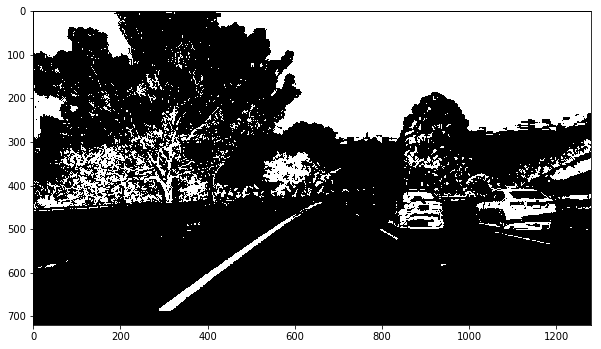

In [780]:
plt.figure(figsize=(10,7))
plt.imshow(s_ch_bin,cmap='gray');

In [849]:
def lane_edges(img,s_thresh=(0,255),rgb_thresh=(0,255),angle_threshs=((0,np.pi/2),(np.pi/2,np.pi))):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    s_ch = color_space_thresh(hls[:,:,2],s_thresh) #(90,255)
    s_ch_bin = np.zeros_like(s_ch)
    s_ch_bin[s_ch.nonzero()] = 1
    
    # select a channel that has good contrast between the white lane markers and
    # road and doesn't have good contrast between the yellow lane markers 

    # turns out the Blue channel seems to do a 
    # pretty good job of finding the things that
    # the S-Channel misses
    B_ch = img[:,:,2]

    binary1 = grad_threshold(B_ch, 
                             gauss_kernel_width=None,#if you wanted to smooth the image it could be done here
                             sobel_kernel=3, 
                             mag_thresh=rgb_thresh,
                             angle_thresh=angle_threshs[0])
    
    binary2 = grad_threshold(B_ch, 
                             gauss_kernel_width=None,
                             sobel_kernel=3, 
                             mag_thresh=rgb_thresh, 
                             angle_thresh=angle_threshs[1])

    # combine both gradient images and the thresheld s-channel
    combined = np.zeros_like(B_ch)
    combined[(binary1==1)|(binary2==1)|(s_ch_bin==1)]=1
    
    return combined

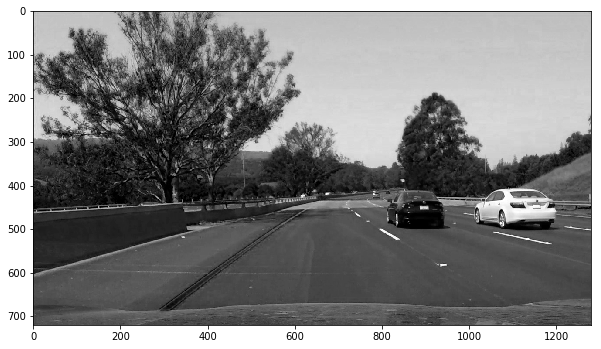

In [844]:
# Plot the input channel
plt.figure(figsize=(10,7))
plt.imshow(raw,cmap='gray');

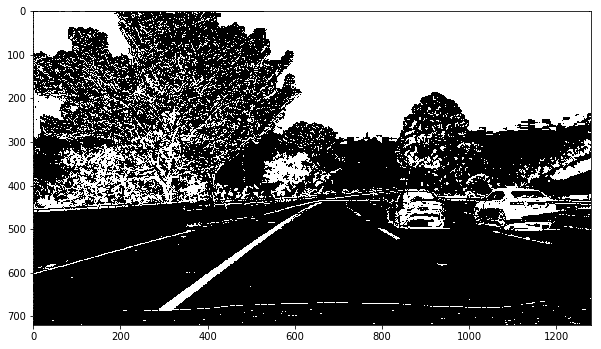

In [845]:
# Plot the gradient + s-channel results
plt.figure(figsize=(10,7))
plt.imshow(combined,cmap='gray');

It's important to note that in the gradient calculation, the gradient directions are selected to have angles from $0$ degress to $95$ degrees and $110$ to $180$.  This filters out change from asphalt to concrete in the above image because in the gradient calculation, the direction of the gradient is within the nearly vertical region and we want to filter out those types of pixel changes. An important test of this is when we negate the image such that the asphalt to concrete transition is reversed in the image. We want to find that we still do not detect the transition edge, this is done below.

In [860]:
lanes = lane_edges(~img,
                   s_thresh=(90,255),
                   rgb_thresh=(20,255),
                   angle_threshs=((0,70*np.pi/180.),(120*np.pi/180.,np.pi)))

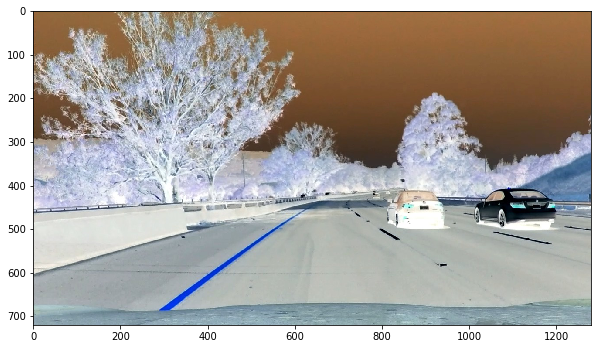

In [862]:
plt.figure(figsize=(10,7))
plt.imshow(~img,cmap='gray');

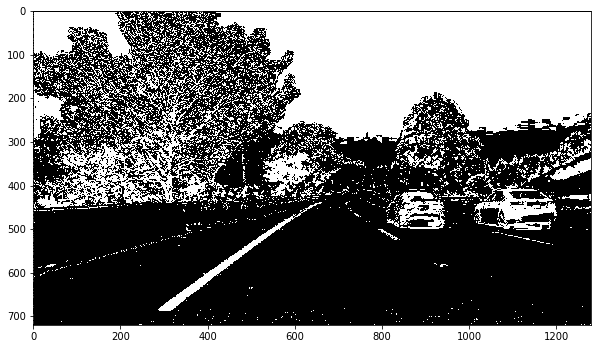

In [864]:
# looks good!
plt.figure(figsize=(10,7))
plt.imshow(lanes,cmap='gray');

The final step is application of an image mask into a region of interest so that we only focus on the lane pixels.

In [939]:
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def lane_edges_ROI(img,s_thresh=(0,255),rgb_thresh=(0,255),angle_threshs=((0,np.pi/2),(np.pi/2,np.pi))):
    lanes = lane_edges(img,s_thresh,rgb_thresh,angle_threshs)
    
    ydim,xdim,_ = img.shape
    
    # this is hard coded and in general should be dynamic but im not 
    # sure right now what would be the best way to implement that...
    roi_mask = np.int32([[[int(0.2*xdim),int(0.92*ydim)],
                          [int(0.48*xdim),int(0.58*ydim)],
                          [int(0.58*xdim),int(0.58*ydim)],
                          [int(0.85*xdim),int(0.92*ydim)]]])
    result = region_of_interest(lanes,roi_mask)
    return result

In [940]:
lanes_roi = lane_edges_ROI(img,
                   s_thresh=(90,255),
                   rgb_thresh=(20,255),
                   angle_threshs=((0,70*np.pi/180.),(120*np.pi/180.,np.pi)))

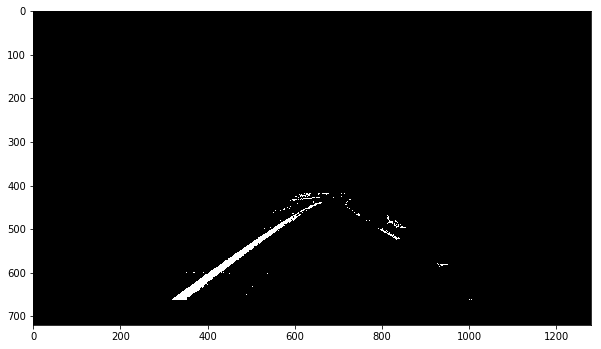

In [941]:
plt.figure(figsize=(10,7))
plt.imshow(lanes_roi,cmap='gray');

### Prepsective Change to the Birds Eye View

Now that we have a pretty good way of detecting lane markers in various lighting conditions, we want to change the perspective of the image such that we have a birds eye view of the lane.  This can be done by warping the image in the same way we reoriented the chessboard earlier.  Of course this is done AFTER applying the calibration step.

In [942]:
#undistort image
undistort_lanes = cv2.undistundistort_lanesort(lanes_roi, mtx, dist, None, mtx)

In [1350]:
# we have a lot of black pixels here so lets recrop the image
ydim,xdim = undistort_lanes.shape

src = np.int32([[0.23*xdim,0.92*ydim],#lower left
                [0.23*xdim,0.55*ydim], #upper left
                [0.85*xdim,0.55*ydim], #upper right
                [0.85*xdim,0.92*ydim]])#lower right

xmin,xmax = np.int32((0.23*xdim,0.85*xdim))
ymin,ymax = np.int32((0.60*ydim,0.92*ydim))

crop_img = undistort_lanes[ymin:ymax,xmin:xmax]

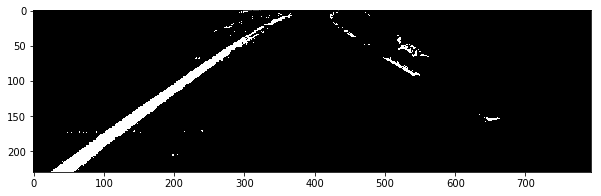

In [1351]:
plt.figure(figsize=(10,7))
plt.imshow(crop_img,cmap='gray');

In [1356]:
ydim,xdim = crop_img.shape

# lets set our warp points
src = np.float32([[0.02*xdim,1.0*ydim],#lower left
                  [0.40*xdim,0.01*ydim], #upper left
                  [0.57*xdim,0.01*ydim], #upper right
                  [0.99*xdim,1.0*ydim]])#lower right


# destination points
ulx,uly = 0.4*xdim,0.01*ydim
lrx,lry = 0.57*xdim,1.0*ydim


# destination cordinates is perfect rectangle
dst = np.float32([[ulx*1.15,lry],[ulx,uly],[lrx,uly],[lrx*0.89,lry]])

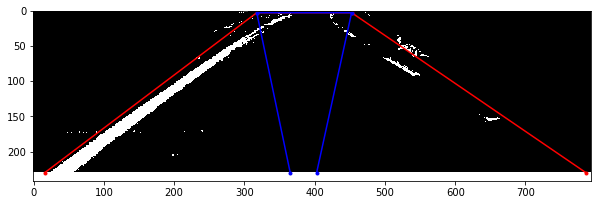

In [1357]:
# showing the source (red) to desintation (blue) points
plt.figure(figsize=(10,7))
plt.imshow(crop_img,cmap='gray')
plt.plot(src.T[0],src.T[1],marker='.',c='r');
plt.plot(dst.T[0],dst.T[1],marker='.',c='b');

In [1358]:
# get the linear warp matrix
M = cv2.getPerspectiveTransform(src,dst)
img_shape = (int(dst[0,1]-dst[1,1]),int(dst[-1,0]-dst[0,0]))
bev_lanes = cv2.warpPerspective(crop_img, M, crop_img.shape[::-1], flags=cv2.INTER_LINEAR)

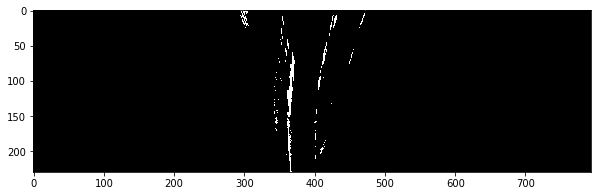

In [1359]:
plt.figure(figsize=(10,7))
plt.imshow(bev_lanes,cmap='gray');

### Pixel Segregation

Now we need to fit the over head views to 2nd degree polynomials.  To do that we need to pass over the data and find the relevant points associated with the lanes and not any shadows or other edges.  A nice way presented in the course is to use pixel histograms across columns for windows which move from the bottom of the image to the top.  By taking weighitng high pixel densities by their distance to the previous lane point you essentially make something akin to a Bayesian belief network as it moves along the windows to find the pixels associated with the lanes. 

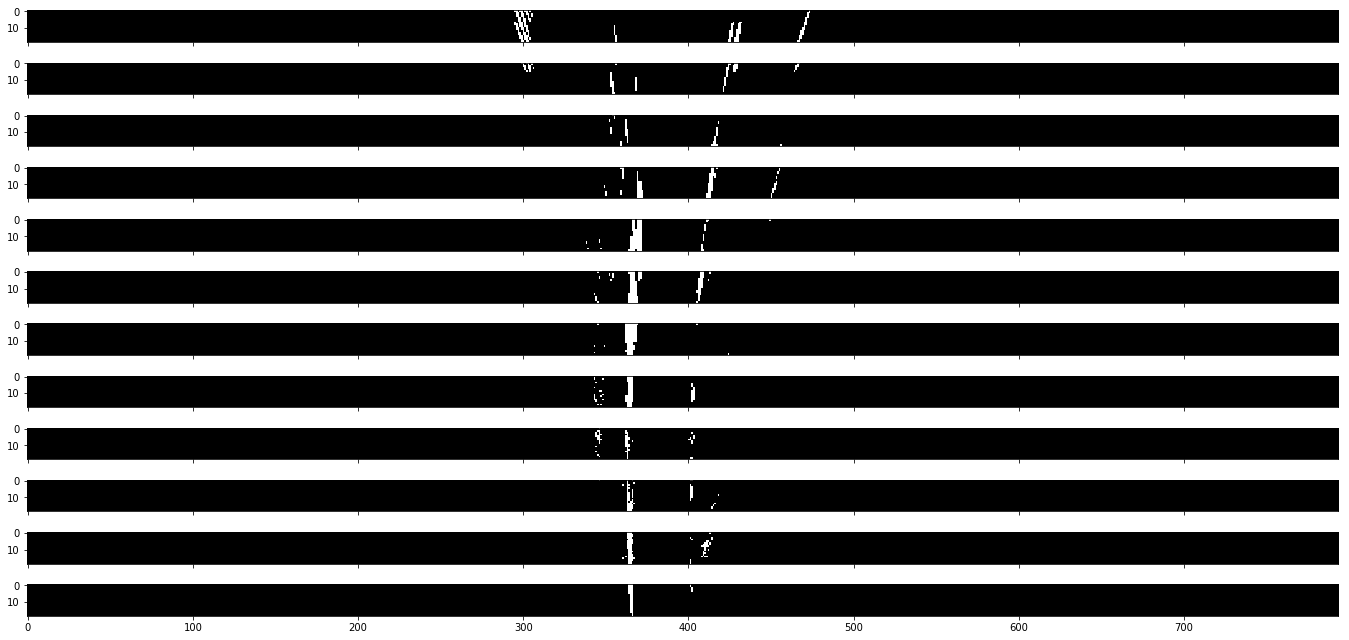

In [1363]:
# Choose the number of sliding windows
nwindows = 12

# Set height of windows - based on nwindows above and image shape
window_height = np.int(bev_lanes.shape[0]//nwindows)

# lets look at the windows
f, axs = plt.subplots(nwindows,1, figsize=(24, 9),sharex=True,sharey=True)
f.tight_layout()

for w in range(nwindows):
    slice = bev_lanes[(nwindows-w-1)*window_height:(nwindows-w)*window_height,:]
    axs[-(w+1)].imshow(slice,cmap='gray');

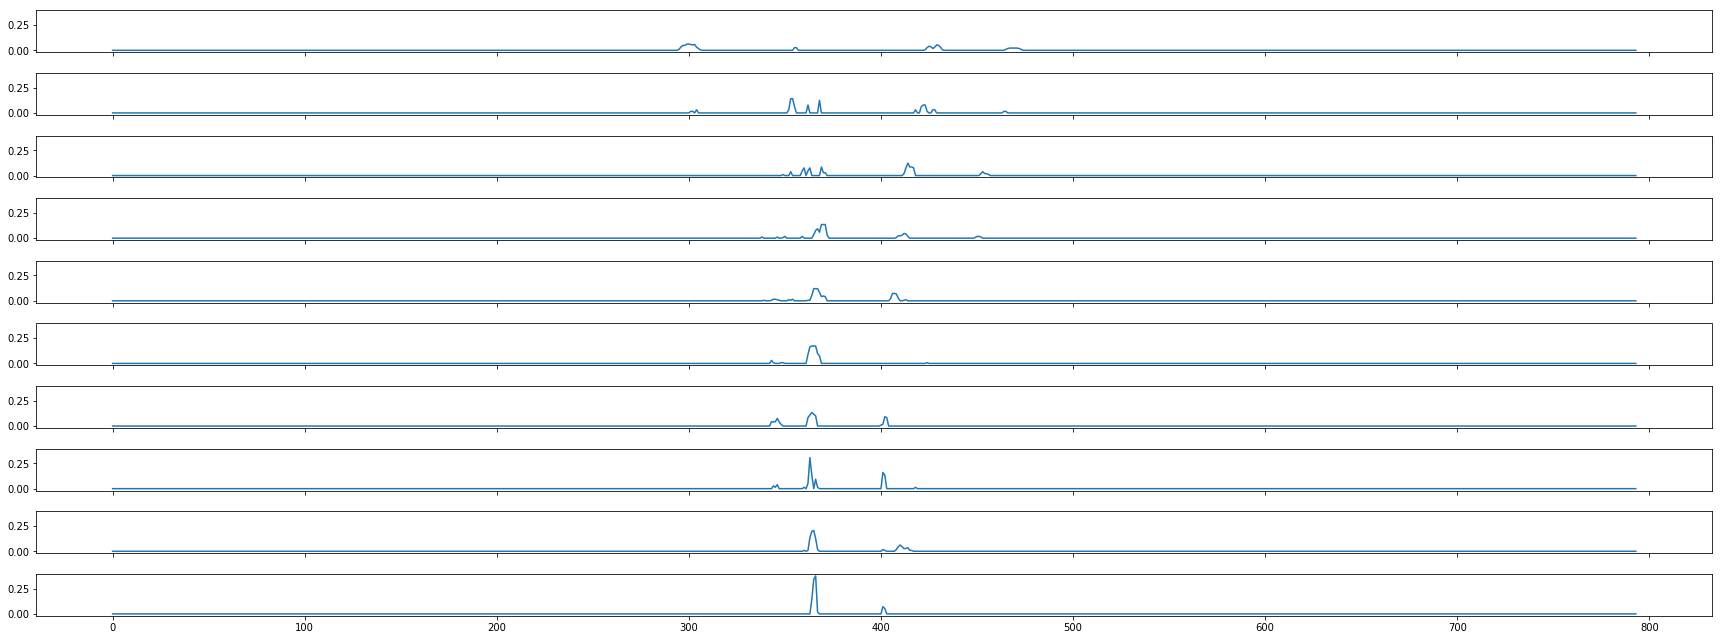

In [1550]:
f, axs = plt.subplots(nwindows,1, figsize=(24, 9),sharex=True,sharey=True)
f.tight_layout()

for w in range(nwindows):
    slice = bev_lanes[(nwindows-w-1)*window_height:(nwindows-w)*window_height,:]
    npxls = np.sum(slice)
    histo = np.sum(slice,axis=0)/npxls
    axs[-(w+1)].plot(histo);

In [1776]:
# inital uncertainty in pixels
# of the size of the closest lane marker
s2 = 5.0

# the number of pixels seen to be able to update 
# the posterior
thresh = 1.0

# intialize the looking region
midline = bev_lanes.shape[1]//2

# container to hold pixels that are accepted
# as part of the lanes
left_pxls = np.array([[0,0]])
right_pxls = np.array([[0,0]])

# nonzero pixels in (y,x) form in whole image
hot_pxls = np.vstack(bev_lanes.nonzero()).T

# sample points of the posterior pdfs
x = np.array(range(bev_lanes.shape[1]))

for w in range(nwindows):
    # find the slice columns
    ylo,yhi = (nwindows-w-1)*window_height,(nwindows-w)*window_height
    slice = bev_lanes[ylo:yhi,:]
    
    # compute pixel histograms marginalized over the rows
    histo_L = np.sum(slice[:,:midline],axis=0)
    histo_R = np.sum(slice[:,midline:],axis=0)
    
    # find the max of the histograms
    est_muL = np.argmax(histo_L)
    est_muR = midline + np.argmax(histo_R)
    
    # making sure the max of the histogram 
    # is a valid number of pixels
    Lmax = np.max(histo_L)
    Rmax = np.max(histo_R)
    
    
    if w == 0:
        pdf_L = np.exp(-(x-est_muL)**2/(2.*s2))
        maxp = np.max(pdf_L)
        pdf_L = pdf_L/maxp
        #print('maxL p', maxp)
        pdf_R = np.exp(-(x-est_muR)**2/(2.*s2))
        maxp = np.max(pdf_R)
        pdf_R = pdf_R/maxp
    else:
        pdf_L = pdf_L_old*(np.exp(-(x-est_muL)**2/(2.*s2)))
        # rescale pdf_L
        maxp = np.max(pdf_L)
        #print('maxL p2', maxp)
        pdf_L = pdf_L/maxp
        
        pdf_R = pdf_R_old*(np.exp(-(x-est_muR)**2/(2.*s2)))
        # rescale pdf_R
        maxp = np.max(pdf_R)
        #print('maxR p2', maxp)
        pdf_R = pdf_R/maxp
    
    if (Lmax > thresh) or (w == 0):
        left_mle_x = np.argmax(pdf_L)
    if (Rmax > thresh) or (w == 0):
        right_mle_x = np.argmax(pdf_R)
    
    midline = int((left_mle_x+right_mle_x)/2.)

    
    # selecting the pixels in the mle area
    # for the left lane
    pdf_s = s2
    lo,hi = int(left_mle_x-pdf_s),int(left_mle_x+pdf_s)
    if lo < 0:
        lo = 0
    if hi > slice.shape[1]:
        hi = slice.shape[1]
        
    x_pxls = hot_pxls[ (hot_pxls[:,0] >= ylo) & (hot_pxls[:,0] < yhi) &\
                       (hot_pxls[:,1] >= lo) & (hot_pxls[:,1] < hi)]
    
    if len(x_pxls) > 0:
        left_pxls = np.vstack((left_pxls,x_pxls))
    
    # selecting the pixels in the mle area
    # for the right lane
    lo,hi = int(right_mle_x-pdf_s),int(right_mle_x+pdf_s)
    if lo < 0:
        lo = 0
    if hi > slice.shape[1]:
        hi = slice.shape[1]
    
    x_pxls = hot_pxls[ (hot_pxls[:,0] >= ylo) & (hot_pxls[:,0] < yhi) &\
                       (hot_pxls[:,1] >= lo) & (hot_pxls[:,1] < hi)]
    
    if len(x_pxls) > 0:
        right_pxls = np.vstack((right_pxls,x_pxls))
    
    # priors for the next iteration
    pdf_L_old = pdf_L
    pdf_R_old = pdf_R
    
    # reducing confidence as I move verticly
    # for the next iteration this also expands the window
    # of acceptable pixels further away from the camera
    s2 *= 1.3

In [1777]:
hilight_right = np.zeros_like(bev_lanes)

for pxly,pxlx in right_pxls:
    hilight_right[pxly,pxlx] = 255

hilight_left = np.zeros_like(bev_lanes)

for pxly,pxlx in left_pxls:
    hilight_left[pxly,pxlx] = 255
    
combined = np.dstack([hilight_right,hilight_left,bev_lanes*255])

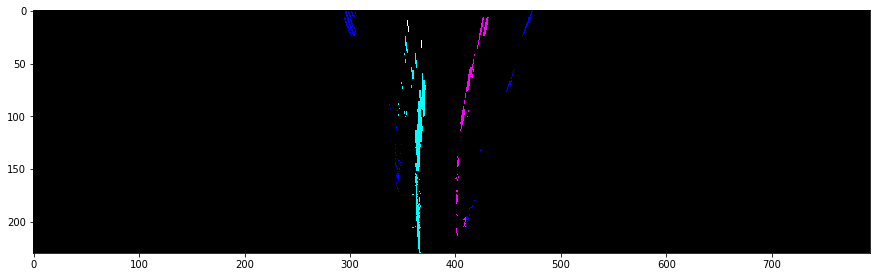

In [1779]:
plt.figure(figsize=(15,10))
plt.imshow(combined);

In [ ]:
def seperate_lane_pxls(bin_img,nwindows=10,initial_uncertainty=5.0)
    # inital uncertainty in pixels
    # of the size of the closest lane marker
    s2 = initial_uncertainty

    # the number of pixels seen to be able to update 
    # the posterior
    thresh = 1.0

    # intialize the looking region
    midline = bin_img.shape[1]//2

    # container to hold pixels that are accepted
    # as part of the lanes
    left_pxls = np.array([[0,0]])
    right_pxls = np.array([[0,0]])

    # nonzero pixels in (y,x) form in whole image
    hot_pxls = np.vstack(bin_img.nonzero()).T

    # sample points of the posterior pdfs
    sample_x = np.array(range(bin_img.shape[1]))
    
    # number of rows in a slice
    window_hight = np.int(binnwindows)

    for w in range(nwindows):
        # find the slice columns
        ylo,yhi = (nwindows-w-1)*window_height,(nwindows-w)*window_height
        slice = bev_lanes[ylo:yhi,:]
    
    # compute pixel histograms marginalized over the rows
    histo_L = np.sum(slice[:,:midline],axis=0)
    histo_R = np.sum(slice[:,midline:],axis=0)
    
    # find the max of the histograms
    est_muL = np.argmax(histo_L)
    est_muR = midline + np.argmax(histo_R)
    
    # making sure the max of the histogram 
    # is a valid number of pixels
    Lmax = np.max(histo_L)
    Rmax = np.max(histo_R)
    
    
    if w == 0:
        pdf_L = np.exp(-(x-est_muL)**2/(2.*s2))
        maxp = np.max(pdf_L)
        pdf_L = pdf_L/maxp
        #print('maxL p', maxp)
        pdf_R = np.exp(-(x-est_muR)**2/(2.*s2))
        maxp = np.max(pdf_R)
        pdf_R = pdf_R/maxp
    else:
        pdf_L = pdf_L_old*(np.exp(-(x-est_muL)**2/(2.*s2)))
        # rescale pdf_L
        maxp = np.max(pdf_L)
        #print('maxL p2', maxp)
        pdf_L = pdf_L/maxp
        
        pdf_R = pdf_R_old*(np.exp(-(x-est_muR)**2/(2.*s2)))
        # rescale pdf_R
        maxp = np.max(pdf_R)
        #print('maxR p2', maxp)
        pdf_R = pdf_R/maxp
    
    if (Lmax > thresh) or (w == 0):
        left_mle_x = np.argmax(pdf_L)
    if (Rmax > thresh) or (w == 0):
        right_mle_x = np.argmax(pdf_R)
    
    midline = int((left_mle_x+right_mle_x)/2.)

    
    # selecting the pixels in the mle area
    # for the left lane
    pdf_s = s2
    lo,hi = int(left_mle_x-pdf_s),int(left_mle_x+pdf_s)
    if lo < 0:
        lo = 0
    if hi > slice.shape[1]:
        hi = slice.shape[1]
        
    x_pxls = hot_pxls[ (hot_pxls[:,0] >= ylo) & (hot_pxls[:,0] < yhi) &\
                       (hot_pxls[:,1] >= lo) & (hot_pxls[:,1] < hi)]
    
    if len(x_pxls) > 0:
        left_pxls = np.vstack((left_pxls,x_pxls))
    
    # selecting the pixels in the mle area
    # for the right lane
    lo,hi = int(right_mle_x-pdf_s),int(right_mle_x+pdf_s)
    if lo < 0:
        lo = 0
    if hi > slice.shape[1]:
        hi = slice.shape[1]
    
    x_pxls = hot_pxls[ (hot_pxls[:,0] >= ylo) & (hot_pxls[:,0] < yhi) &\
                       (hot_pxls[:,1] >= lo) & (hot_pxls[:,1] < hi)]
    
    if len(x_pxls) > 0:
        right_pxls = np.vstack((right_pxls,x_pxls))
    
    # priors for the next iteration
    pdf_L_old = pdf_L
    pdf_R_old = pdf_R
    
    # reducing confidence as I move verticly
    # for the next iteration this also expands the window
    # of acceptable pixels further away from the camera
    s2 *= 1.3

### Radius of curvature of the lane and the position of the vehicle

I did this in lines # through # in my code in `my_other_file.py`

### Plotted back down onto the road

I implemented this step in lines # through # in my code in `yet_another_file.py` in the function `map_lane()`.  Here is an example of my result on a test image:

![alt text][image6]

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to my video result](./project_video.mp4)  

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.